In [1]:
from cavity import *

ALREADY_CHANGED_DIR = 0
try:
    from IPython import get_ipython
    shell = get_ipython()
    running_in_notebook = shell is not None and shell.__class__.__name__ == "ZMQInteractiveShell"
    if ALREADY_CHANGED_DIR == 0:
        import os
        os.chdir('..')
    ALREADY_CHANGED_DIR = 1
except Exception:
    running_in_notebook =  False
    from matplotlib import use
    use('TkAgg')


def point_of_equal_angles(ray_1: Ray, ray_2: Ray, p_1: np.ndarray):
    # projects point p_1 (assumed to be on ray_1) onto ray_2 such that the angles between the segment p_1 to p_2 and the rays are equal.
    p_1_minus_u_2 = p_1 - ray_2.origin
    k_1_plus_k_2 = ray_1.k_vector + ray_2.k_vector
    denominator = 1 + ray_1.k_vector @ ray_2.k_vector
    t = (p_1_minus_u_2 @ k_1_plus_k_2) / denominator
    p_2 = ray_2.origin + t * ray_2.k_vector
    # For debugging:
    # ray_1 = Ray(origin=np.array([1, 1, 0]), k_vector=normalize_vector(np.array([1, -1, 0])))
    # ray_2 = Ray(origin=np.array([0, 1, 0]), k_vector=normalize_vector(np.array([-21, -1, 0])))
    # p_1 = ray_1.parameterization(3)
    # p_2 = point_of_equal_angles(ray_1, ray_2, p_1)
    #
    # fig, ax = plt.subplots()
    # ax.plot([ray_1.origin[0], p_1[0]], [ray_1.origin[1], p_1[1]], color='blue', label='Ray 1')
    # ax.plot([ray_2.origin[0], p_2[0]], [ray_2.origin[1], p_2[1]], color='red', label='Ray 2')
    # ax.scatter(p_1[0], p_1[1], color='green', label='Point on Ray 1')
    # ax.scatter(p_2[0], p_2[1], color='orange', label='Point of Equal Angles')
    # ax.plot([p_1[0], p_2[0]], [p_1[1], p_2[1]], color='black', linestyle='--', label='Connecting Line')
    # ax.set_aspect('equal', 'box')
    # ax.legend()
    # plt.show()
    return p_2


def points_of_equal_phase(ray: Ray, reference_point: np.ndarray):
    # Generate points of equal phase along an array of rays, starting from a reference point on the first ray.
    points = np.zeros_like(ray.origin)
    points[0, :] = reference_point
    for i in range(1, len(ray.origin)):  # Make sure it returns what I want:
        p_2 = point_of_equal_angles(ray_1=ray[i-1], ray_2=ray[i], p_1=points[i - 1, :])
        points[i, :] = p_2
    return points

def find_wavefront_deviation(cavity: Cavity,
                             max_initial_angle: float,
                             n_rays=100,
                             plot_potential_fits=True,
                             potential_fits_x_axis='arc_length',  # 'arc_length' or 'tilt_angle'
                             plot_wavefronts=True,
                             plot_first_mirror_arc=False,
                             secondary_axis_limits=None,  # (x_min, x_max, y_min, y_max)
                             print_summary=True,
                             suptitles: Optional[Union[List[str], str]]=None,
                             angles_parity_sign: int = -1  # 1 if ray that starts ascending from first mirror reaches
                            # last mirror while still ascending (like in Fabry-Perot), -1 otherwise (like in mirror-lens-mirror)
                             ):
    first_mirror = cavity.physical_surfaces[0]
    last_mirror = cavity.physical_surfaces[-1]
    tilt_angles = np.linspace(0, max_initial_angle, n_rays)
    initial_arc_lengths = tilt_angles * first_mirror.radius
    initial_rays_origin = first_mirror.parameterization(np.zeros_like(initial_arc_lengths), -initial_arc_lengths)
    orthonormal_direction = unit_vector_of_angles(theta=np.zeros_like(tilt_angles), phi=tilt_angles + np.pi * (1 - first_mirror.inwards_normal[0])/2)  # Assume system is alligned with x axis
    orthonormal_ray = Ray(origin=initial_rays_origin, k_vector=orthonormal_direction)
    ray_history = cavity.trace_ray(orthonormal_ray, n_arms=len(cavity.physical_surfaces) - 1)
    intersection_points = ray_history[-1].origin
    intersection_directions = ray_history[-2].k_vector
    intersection_normals = normalize_vector(intersection_points - last_mirror.origin)
    sin_theta = np.cross(intersection_normals, intersection_directions)[:, 2] * angles_parity_sign
    incidence_angles = np.arcsin(sin_theta)
    incremental_arc_lengths = np.linalg.norm(intersection_points[1:, :] - intersection_points[:-1, :], axis=-1)
    incremental_arc_lengths = np.concatenate(([0], incremental_arc_lengths))
    integrated_arc_lengths = np.cumsum(incremental_arc_lengths)

    integrated_divergence = np.cumsum(incidence_angles * incremental_arc_lengths)
    points_of_equal_phase_values = points_of_equal_phase(ray=ray_history[-2],
                                                         reference_point=ray_history[-1].origin[0, :])
    points_of_equal_phase_values_distance_from_face = last_mirror.radius - np.linalg.norm(
        points_of_equal_phase_values - last_mirror.origin, axis=-1)

    integrated_arc_lengths_doubled = np.concatenate(
        (-integrated_arc_lengths[1:][::-1], integrated_arc_lengths))
    integrated_divergence_doubled = np.concatenate((integrated_divergence[1:][::-1], integrated_divergence))
    points_of_equal_phase_values_distance_from_face_doubled = np.concatenate((
        points_of_equal_phase_values_distance_from_face[1:][::-1], points_of_equal_phase_values_distance_from_face))
    tilt_angles_doubled = np.concatenate((-tilt_angles[1:][::-1], tilt_angles))

    if potential_fits_x_axis == 'arc_length':
        x_data = integrated_arc_lengths_doubled
    else:
        x_data = tilt_angles_doubled
    polynomial_coefficients_angles_doubled = np.polyfit(x_data, integrated_divergence_doubled, deg=4)
    polynomial_coefficients_wavefront_doubled = np.polyfit(x_data, points_of_equal_phase_values_distance_from_face_doubled, deg=4)

    results_dict = {
        'first_mirror': first_mirror,
        'last_mirror': last_mirror,
        'tilt_angles': tilt_angles,
        'ray_history': ray_history,
        'intersection_points': intersection_points,
        'intersection_directions': intersection_directions,
        'intersection_normals': intersection_normals,
        'incidence_angles': incidence_angles,
        'incremental_arc_lengths': incremental_arc_lengths,
        'integrated_arc_lengths': integrated_arc_lengths,
        'integrated_divergence': integrated_divergence,
        'points_of_equal_phase_values': points_of_equal_phase_values,
        'points_of_equal_phase_values_distance_from_face': points_of_equal_phase_values_distance_from_face,
        'polynomial_coefficients_angles_doubled': polynomial_coefficients_angles_doubled,
        'polynomial_coefficients_wavefront_doubled': polynomial_coefficients_wavefront_doubled
    }

    if isinstance(suptitles, str):
        suptitles = [suptitles, suptitles]
    if plot_potential_fits:
        x_fit = np.linspace(np.min(integrated_arc_lengths_doubled), np.max(integrated_arc_lengths_doubled), 100)
        y_fit_angles = np.polyval(polynomial_coefficients_angles_doubled, x_fit)
        y_fit_wavefront = np.polyval(polynomial_coefficients_wavefront_doubled, x_fit)
        fig_0, ax_0 = plt.subplots(2, 1, figsize=(10, 10))
        if potential_fits_x_axis == 'arc_length':
            x_axis_name = 'integrated arc length'
            x_axis_label = 'Integrated Arc Length (m)'
            x_data = integrated_arc_lengths_doubled
        else:
            x_axis_name = 'initial tilt angle'
            x_axis_label = 'Initial Tilt Angle (rad)'
            x_data = tilt_angles_doubled
        ax_0[0].scatter(x_data, integrated_divergence_doubled, color='blue', s=5, label='Numerical result')
        ax_0[0].plot(x_fit, y_fit_angles, color='red', label='Fitted Polynomial')
        ax_0[0].set_title(f'Integrated Incidence Angle vs {x_axis_name}\nQuadratic coefficient = {polynomial_coefficients_angles_doubled[-3]:.3e}, Quartic coefficient = {polynomial_coefficients_angles_doubled[-5]:.3e}')
        ax_0[0].set_ylabel('Integrated Incidence Angle (m)')
        ax_0[0].legend()
        ax_0[0].grid()
        ax_0[1].scatter(x_data, points_of_equal_phase_values_distance_from_face_doubled, color='green', s=5, label='Numerical result')
        ax_0[1].plot(x_fit, y_fit_wavefront, color='red', label='Fitted Polynomial')
        ax_0[1].set_title(f'Traced wavefront vs {x_axis_name}\nQuadratic coefficient = {polynomial_coefficients_wavefront_doubled[-3]:.3e}, Quartic coefficient = {polynomial_coefficients_wavefront_doubled[-5]:.3e}')
        ax_0[1].set_xlabel(x_axis_label)
        ax_0[1].set_ylabel('Extracted Wavefront Distance from Mirror (m)')
        ax_0[1].legend()
        ax_0[1].grid()

        if suptitles is not None:
            fig_0.suptitle(suptitles[0])
        fig_0.subplots_adjust(top=0.85, hspace=0.4)
        if not running_in_notebook:
            root = fig_0.canvas.manager.window
            root.geometry("+2000+200")
        results_dict['fig_potentials'] = fig_0
        results_dict['ax_potentials'] = ax_0

    if plot_wavefronts:
        fig_1, ax_1 = plt.subplots(2, 1, figsize=(8, 20))
        cavity.plot(ax=ax_1[0], fine_resolution=True, plot_mode_lines=False)
        ax_1[0].scatter(last_mirror.origin[0], last_mirror.origin[1], color='blue', s=10, label='Small Mirror Center')
        for i in np.arange(0, len(tilt_angles), 200):
            for ray in ray_history[:-1]:
                ray[i].plot(ax=ax_1[0], color='green', linewidth=0.5, alpha=0.3, label='Rays' if i == 0 else "")

        cavity.plot(ax=ax_1[1], label='mirror face', fine_resolution=True, plot_mode_lines=False)
        for i in np.arange(0, len(tilt_angles), 50):
            for ray in ray_history[:-1]:
                ray[i].plot(ax=ax_1[1], color='green', linewidth=0.5, alpha=0.3, label='Rays' if i == 0 else "")

        ax_1[0].set_title(f"initial tilt angle = {tilt_angles[-1]:.3e}")
        ax_1[0].plot(points_of_equal_phase_values[:, 0], points_of_equal_phase_values[:, 1], color='purple',
                     linestyle='-.', label='Wavefront')
        ax_1[1].plot(points_of_equal_phase_values[:, 0], points_of_equal_phase_values[:, 1], color='purple',
                     linestyle='-.', label='Wavefront')

        # plot a circle with radius equal to left mirror.radius and around left mirror origin:
        ax_1[1].scatter(intersection_points[::50, 0], intersection_points[::50, 1], color='black',
                     label='Intersection points', alpha=0.8, s=3)

        # plot an arc with the radius of the right arm, with angle between -0.156 to 0.156:
        if plot_first_mirror_arc:
            theta_min = np.min(tilt_angles)
            theta_max = np.max(tilt_angles)
            theta = np.linspace(theta_min, theta_max, 200)
            center = first_mirror.origin[:2]
            r = first_mirror.radius
            arc_x = center[0] + r * np.cos(theta)
            arc_y = center[1] + r * np.sin(theta)
            ax_1[0].plot(arc_x, arc_y, color='red', linewidth=1.5, linestyle='--', label='Left mirror arc', alpha=0.8)
            ax_1[1].plot(arc_x, arc_y, color='red', linewidth=1.5, linestyle='--', label='Left mirror arc', alpha=0.8)
        if secondary_axis_limits is not None:
            ax_1[1].set_xlim(secondary_axis_limits[0], secondary_axis_limits[1])
            ax_1[1].set_ylim(secondary_axis_limits[2], secondary_axis_limits[3])
        leg = ax_1[1].legend()
        handles, labels = leg.legend_handles, [t.get_text() for t in leg.texts]
        # remove the second one (index 1)
        del handles[0:len(cavity.physical_surfaces)-1]
        del labels[00:len(cavity.physical_surfaces)-1]
        ax_1[1].legend(handles, labels)

        ax_1[1].set_title(f"Zoomed in view")
        if suptitles is not None:
            fig_1.suptitle(suptitles[1])
        fig_1.subplots_adjust(top=0.9, hspace=0.5)
        results_dict['fig_wavefronts'] = fig_1
        results_dict['ax_wavefronts'] = ax_1

    if print_summary:
        print(
            f"wavefront distance from mirror according to wave front tracing = {points_of_equal_phase_values_distance_from_face[-1]:.3e}m")
        print(
            f"wavefront distance from mirror according to angle of incidence integration = {integrated_divergence[-1]:.3e}m")
        print(
            f"polynomial quadratic and quartic coefficients for incidence angle integration method: {polynomial_coefficients_angles_doubled[-3]:.3e}, {polynomial_coefficients_angles_doubled[-5]:.3e}")

    return results_dict


base_params = [
    OpticalElementParams(name='Small Mirror', surface_type='curved_mirror', x=-4.999961263669513e-03, y=0, z=0, theta=0,
                         phi=-1e+00 * np.pi, r_1=5e-03, r_2=np.nan, curvature_sign=CurvatureSigns.concave, T_c=np.nan,
                         n_inside_or_after=1e+00, n_outside_or_before=1e+00, diameter=7.75e-3,
                         material_properties=MaterialProperties(refractive_index=None, alpha_expansion=7.5e-08,
                                                                beta_surface_absorption=1e-06,
                                                                kappa_conductivity=1.31e+00, dn_dT=None,
                                                                nu_poisson_ratio=1.7e-01, alpha_volume_absorption=None,
                                                                intensity_reflectivity=9.99889e-01,
                                                                intensity_transmittance=1e-04, temperature=np.nan)),
    OpticalElementParams(name='Lens', surface_type='thick_lens', x=6.387599281689135e-03, y=0, z=0, theta=0, phi=0,
                         r_1=2.422e-02, r_2=5.488e-03, curvature_sign=CurvatureSigns.concave, T_c=2.913797540986543e-03,
                         n_inside_or_after=1.76e+00, n_outside_or_before=1e+00, diameter=7.75e-3,
                         material_properties=MaterialProperties(refractive_index=1.76e+00, alpha_expansion=5.5e-06,
                                                                beta_surface_absorption=1e-06,
                                                                kappa_conductivity=4.606e+01, dn_dT=1.17e-05,
                                                                nu_poisson_ratio=3e-01, alpha_volume_absorption=1e-02,
                                                                intensity_reflectivity=1e-04,
                                                                intensity_transmittance=9.99899e-01,
                                                                temperature=np.nan)),
    OpticalElementParams(name='Big Mirror', surface_type='curved_mirror', x=4.078081462362321e-01, y=0, z=0, theta=0,
                         phi=0, r_1=2e-01, r_2=np.nan, curvature_sign=CurvatureSigns.concave, T_c=np.nan,
                         n_inside_or_after=1e+00, n_outside_or_before=1e+00, diameter=25.4e-3,
                         material_properties=MaterialProperties(refractive_index=None, alpha_expansion=7.5e-08,
                                                                beta_surface_absorption=1e-06,
                                                                kappa_conductivity=1.31e+00, dn_dT=None,
                                                                nu_poisson_ratio=1.7e-01, alpha_volume_absorption=None,
                                                                intensity_reflectivity=9.99889e-01,
                                                                intensity_transmittance=1e-04, temperature=np.nan))
]

# Sanity checks on a fabry perot cavity:

Show that for a fabry perot cavity with 0 unconcentricity, the manifold of equal phase is the mirror itself, and that the intersection angles are all normals:

wavefront distance from right mirror: (both are practically 0, with different numerical errors)
wavefront distance from mirror according to wave front tracing = -1.935e-15m
wavefront distance from mirror according to angle of incidence integration = -7.303e-22m
polynomial quadratic and quartic coefficients for incidence angle integration method: -8.909e-16, -3.950e-10


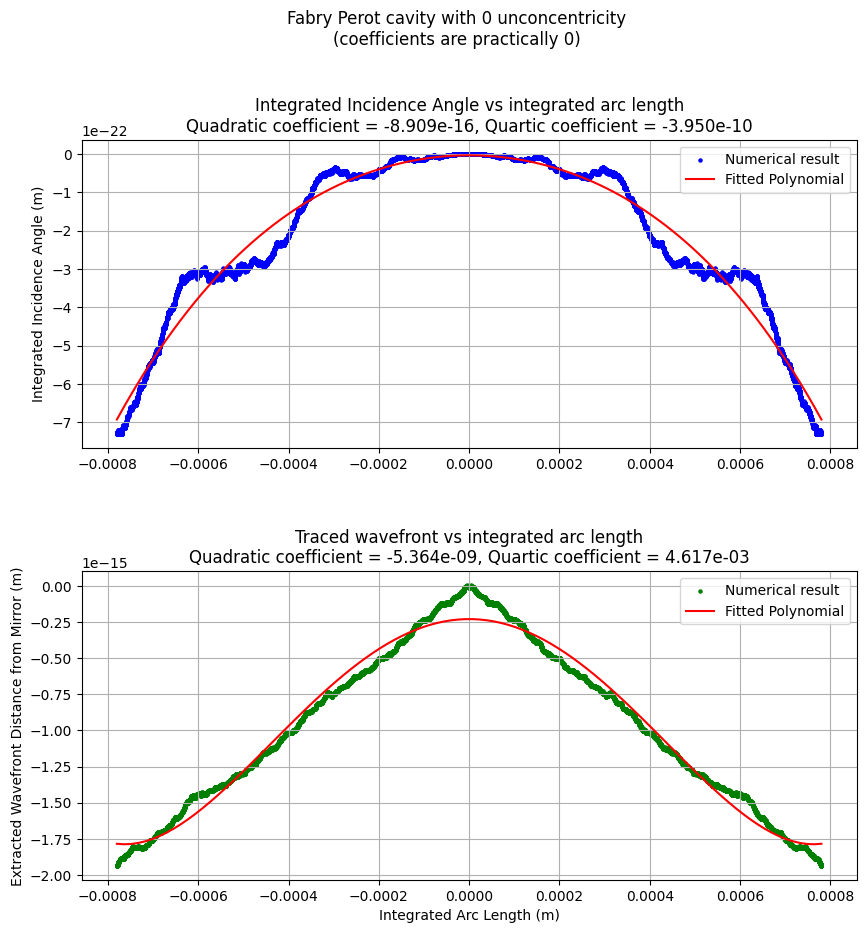

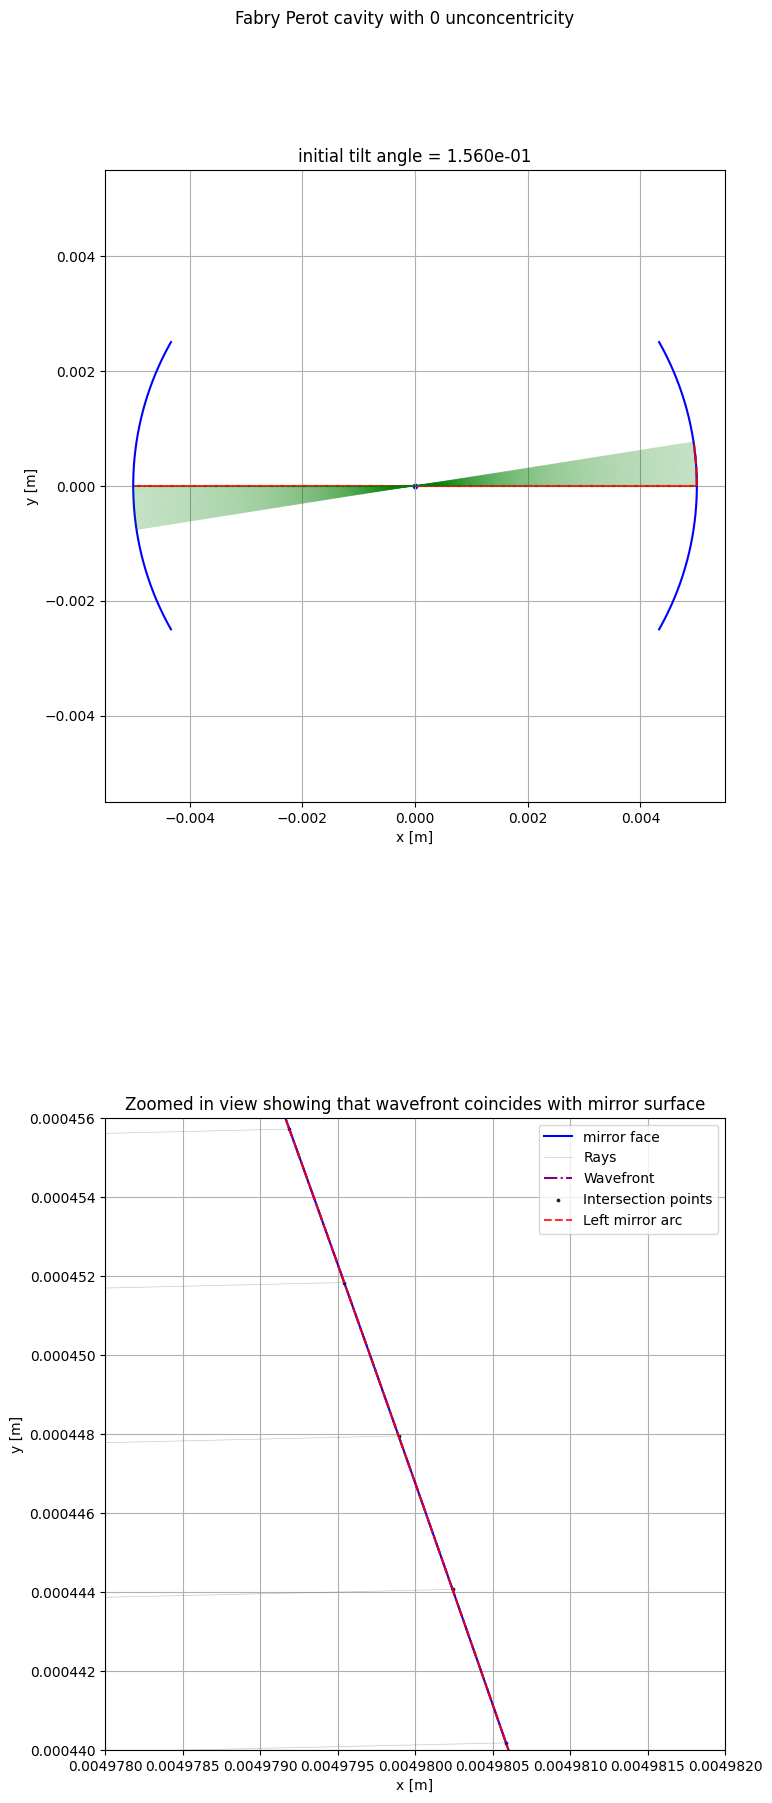

In [2]:
cavity_fabry_perot = fabry_perot_generator(radii=(5e-3, 5e-3), unconcentricity=0e-6, set_mode_parameters=False)
print(f"wavefront distance from right mirror: (both are practically 0, with different numerical errors)")
plt.close('all')
results_dict = find_wavefront_deviation(cavity=cavity_fabry_perot, max_initial_angle=0.156, n_rays=10000,
                                        plot_potential_fits=True, plot_wavefronts=True, plot_first_mirror_arc=True,
                                        secondary_axis_limits=(4.98e-3 - 2e-6, 4.98e-3 + 2e-6, 0.000440, 0.000456),
                                        angles_parity_sign=1,
                                        print_summary=True, suptitles=["Fabry Perot cavity with 0 unconcentricity\n(coefficients are practically 0)", "Fabry Perot cavity with 0 unconcentricity"])
results_dict['ax_wavefronts'][1].set_title("Zoomed in view showing that wavefront coincides with mirror surface")
plt.show()

### This cells shows that unconcentricity initialization of the fabry perot cavity works as expected (resulted numerical NA matches analytic expression):

Calculated NA and expected NA are the same:


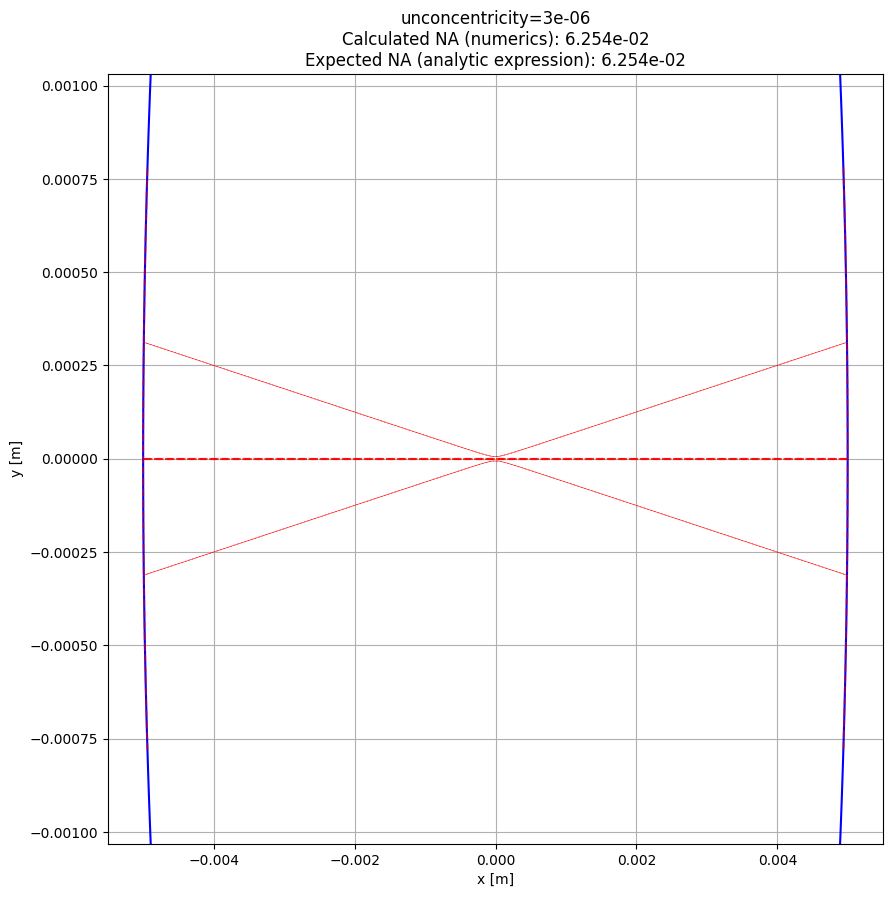

In [3]:
unconcentricity_value = 3e-6
cavity_fabry_perot = fabry_perot_generator(radii=(5e-3, 5e-3), unconcentricity=unconcentricity_value, set_mode_parameters=True)
plt.close('all')
cavity_fabry_perot.plot()
expected_NA = np.sqrt((2 * LAMBDA_0_LASER) / np.pi) * (unconcentricity_value * np.linalg.norm(cavity_fabry_perot.physical_surfaces[0].center - cavity_fabry_perot.physical_surfaces[1].center)) **(-1/4)
plt.title(f"unconcentricity={unconcentricity_value:.0e}\nCalculated NA (numerics): {cavity_fabry_perot.arms[0].mode_parameters.NA[0]:.3e}\nExpected NA (analytic expression): {expected_NA:.3e}")
print("Calculated NA and expected NA are the same:")
plt.show()

### Ray tracing and wavefront tracing for the unconcentric fabry perot cavity:

wavefront distance from right mirror: (both are equal, so different methods agree):
wavefront distance from mirror according to wave front tracing = 3.641e-08m
wavefront distance from mirror according to angle of incidence integration = 3.641e-08m
polynomial quadratic and quartic coefficients for incidence angle integration method: 6.005e-02, -2.084e+02


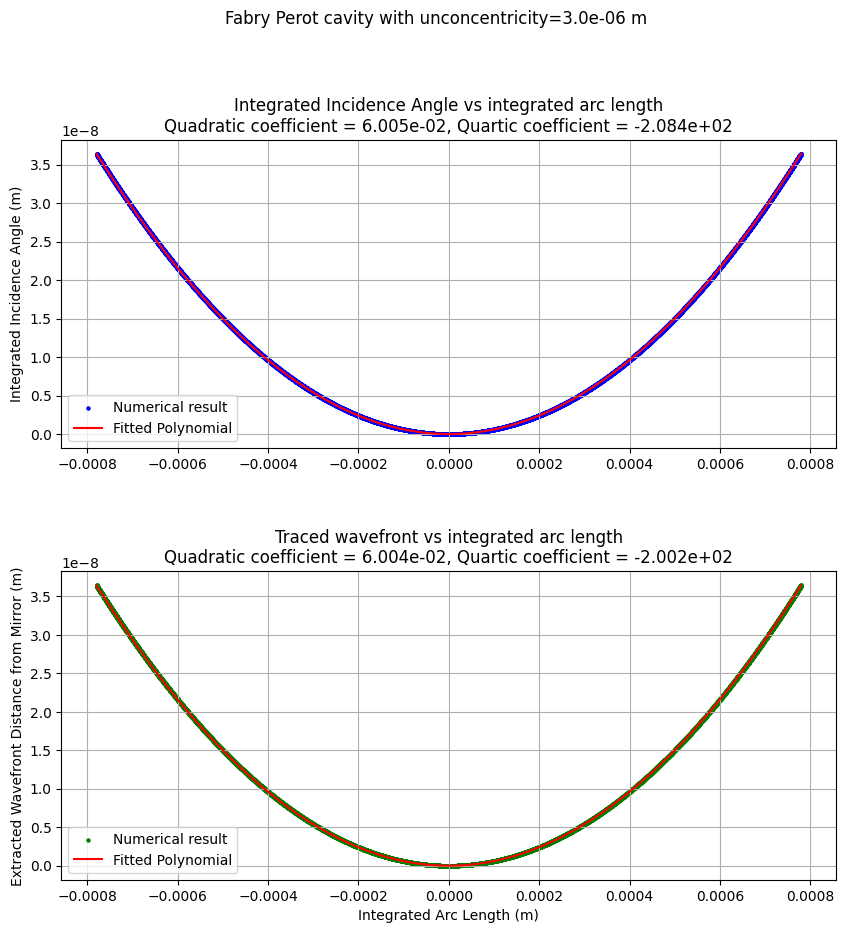

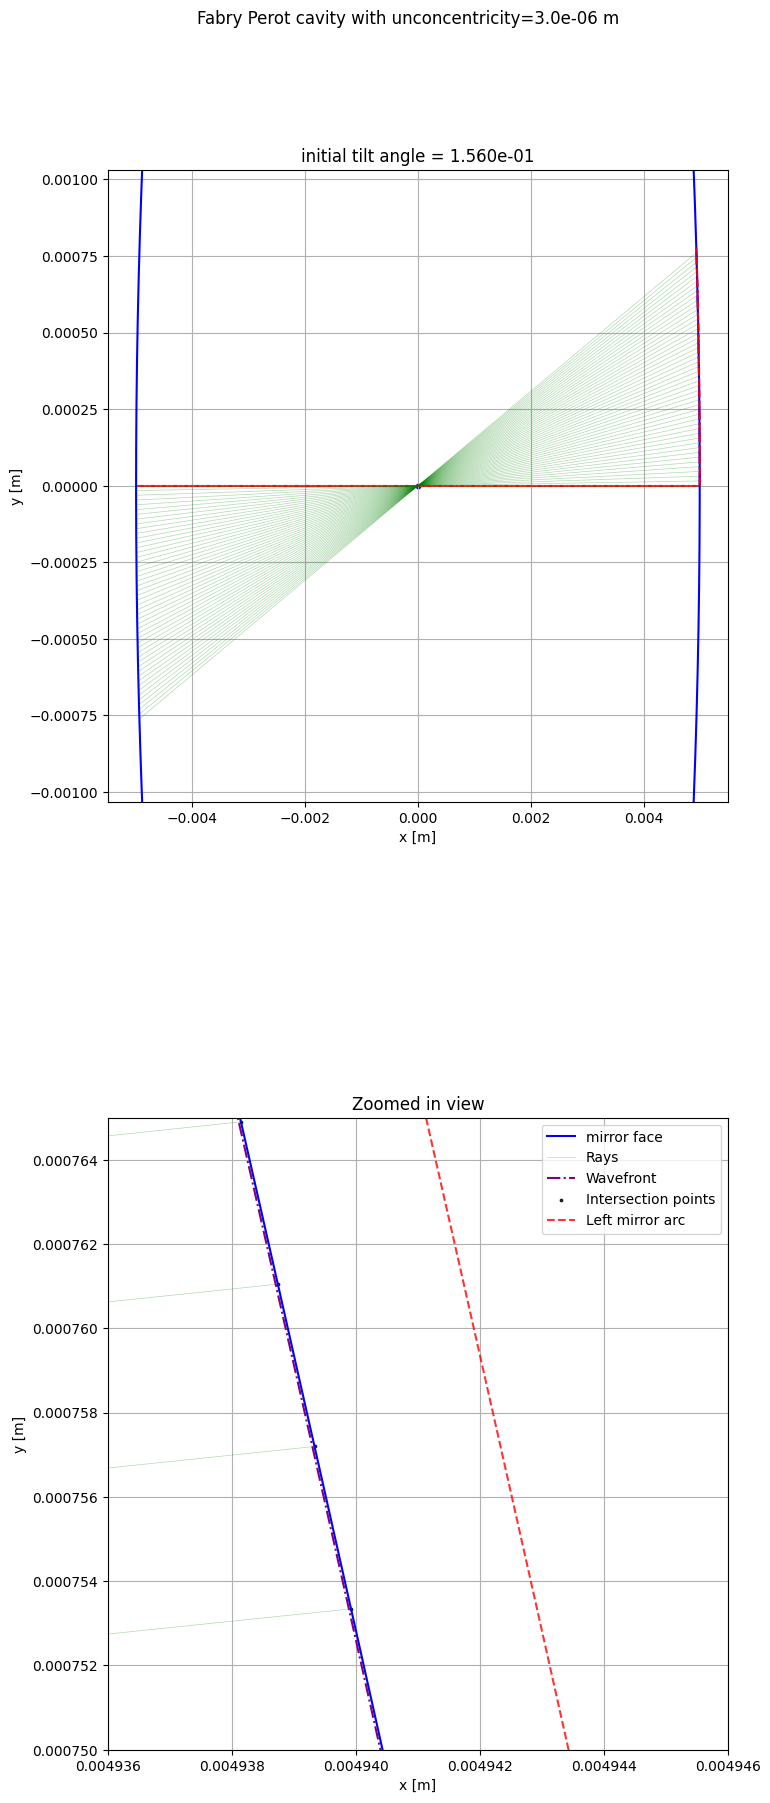

In [4]:
print(f"wavefront distance from right mirror: (both are equal, so different methods agree):")
plt.close('all')
results_dict = find_wavefront_deviation(
    cavity=cavity_fabry_perot, max_initial_angle=0.156, n_rays=10000,
    plot_potential_fits=True,
    plot_wavefronts=True,
    plot_first_mirror_arc=True,
    secondary_axis_limits=(0.004936, 0.004946, 0.000750, 0.000765),
    print_summary=True,
    angles_parity_sign=1,
    suptitles=f"Fabry Perot cavity with unconcentricity={unconcentricity_value:.1e} m")
plt.show()

### Initialize a mirror-lens-mirror cavity with a given unconcentricity for the king arm (should have no mode for 0 unconcentricity, and a diverging mode for small non-zero unconcentricity):

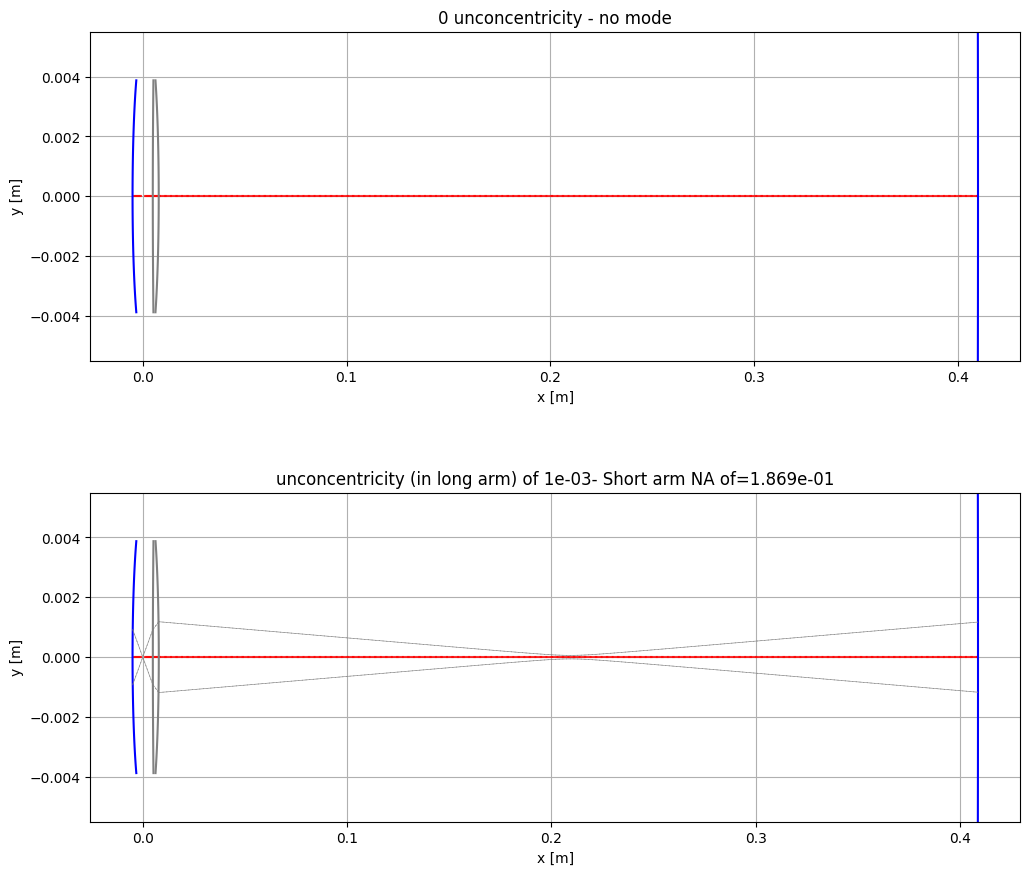

In [5]:
unconcentricity_value=1000e-6
cavity_unconcentricity_0 = mirror_lens_mirror_generator_with_unconcentricity(unconcentricity=0e-6, base_params=base_params)
cavity_unconcentricity_0.plot()
cavity_unconcentricity_small = mirror_lens_mirror_generator_with_unconcentricity(unconcentricity=unconcentricity_value, base_params=base_params)
plt.close('all')
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
cavity_unconcentricity_0.plot(ax=ax[0])
cavity_unconcentricity_small.plot(ax=ax[1])
ax[0].set_title(f"0 unconcentricity - no mode")
ax[1].set_title(f"unconcentricity (in long arm) of {unconcentricity_value:.0e}- Short arm NA of={cavity_unconcentricity_small.arms[0].mode_parameters.NA[0]:.3e}")
fig.subplots_adjust(top=0.9, hspace=0.4)
plt.show()

Aberrations wavefront deviation for the cavity with 0 unconcentricity:

For mirror-lens-mirror there are wavefronts deviations from mirror even for unconcentricity=0 due to aberations
wavefront distance from mirror according to wave front tracing = -7.212e-06m
wavefront distance from mirror according to angle of incidence integration = -7.213e-06m
polynomial quadratic and quartic coefficients for incidence angle integration method: -3.973e-01, -2.365e+04


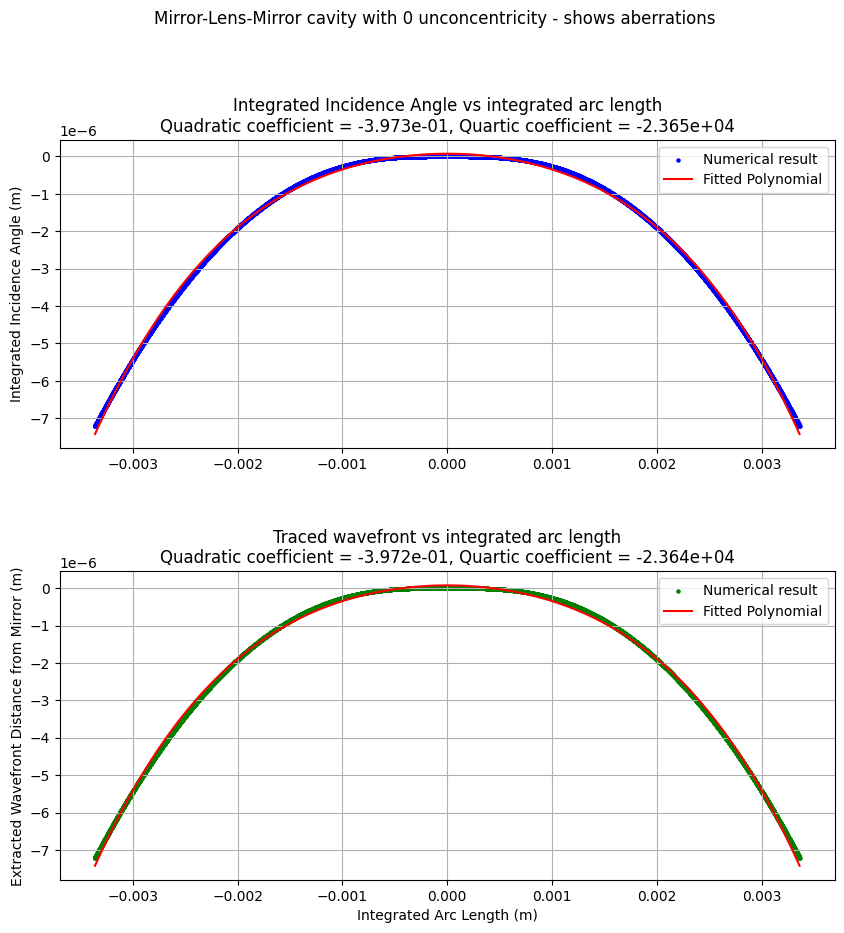

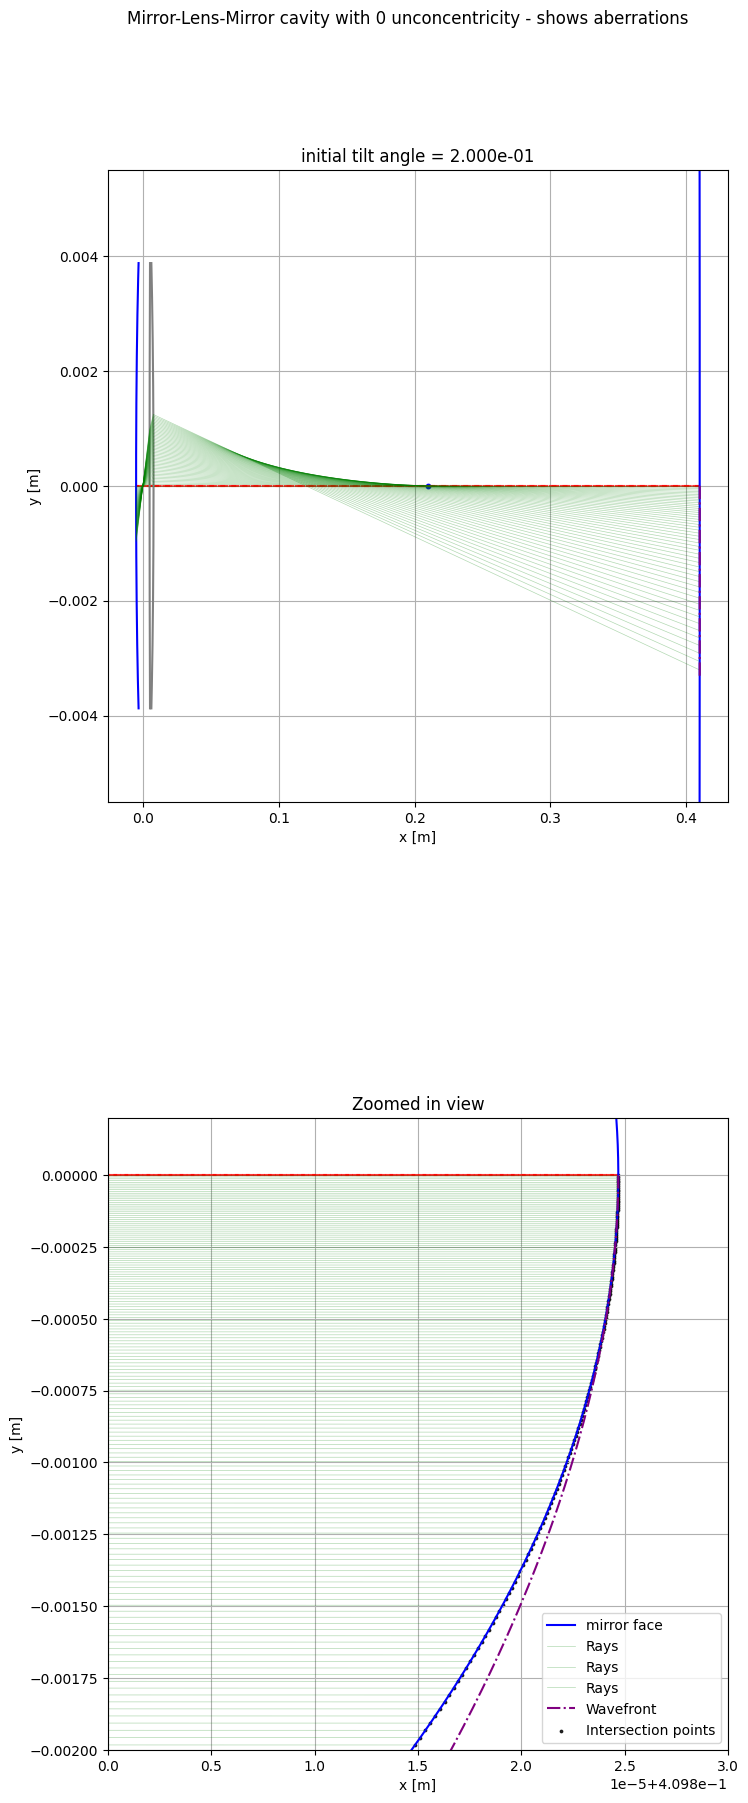

In [6]:
print("For mirror-lens-mirror there are wavefronts deviations from mirror even for unconcentricity=0 due to aberations")
plt.close('all')
results_dict = find_wavefront_deviation(
    cavity=cavity_unconcentricity_0, max_initial_angle=0.2, n_rays=10000, plot_wavefronts=True, plot_potential_fits=True,
    plot_first_mirror_arc=False,secondary_axis_limits=(0.40980, 0.40983, -0.002, 0.0002), print_summary=True,
    angles_parity_sign=-1,
    suptitles="Mirror-Lens-Mirror cavity with 0 unconcentricity - shows aberrations")
plt.show()
df = pd.DataFrame({'initial_angle': results_dict['tilt_angles'],
                   'arc_length': results_dict['integrated_arc_lengths'],
                   'incidence angle': results_dict['incidence_angles'],
                   'distance from mirror': results_dict['integrated_divergence']})
df.to_csv(r'outputs\tables\cavity_angles_small_to_large.csv')

### Aberratmions wavefront deviation for the cavity with a small unconcentricity:

wavefront distance from mirror according to wave front tracing = -3.860e-10m
wavefront distance from mirror according to angle of incidence integration = -3.859e-10m
polynomial quadratic and quartic coefficients for incidence angle integration method: 1.184e-02, -5.920e+05
wavefront distance from mirror according to wave front tracing = -3.860e-10m
wavefront distance from mirror according to angle of incidence integration = -3.859e-10m
polynomial quadratic and quartic coefficients for incidence angle integration method: 5.179e-07, -1.045e-03


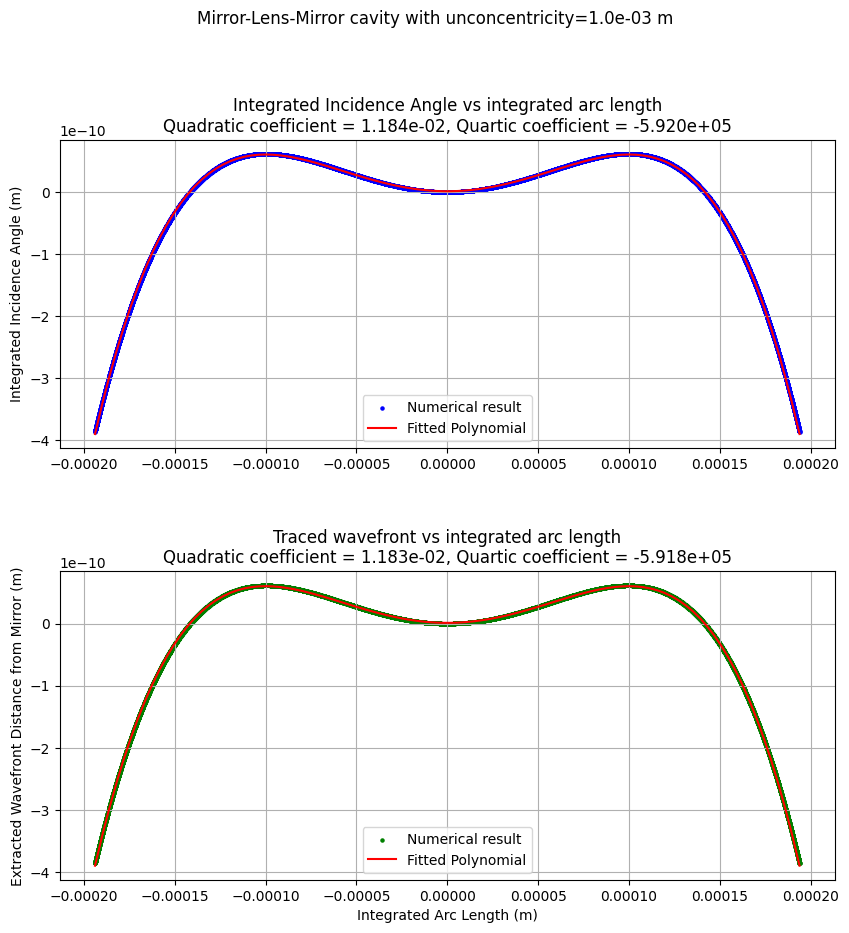

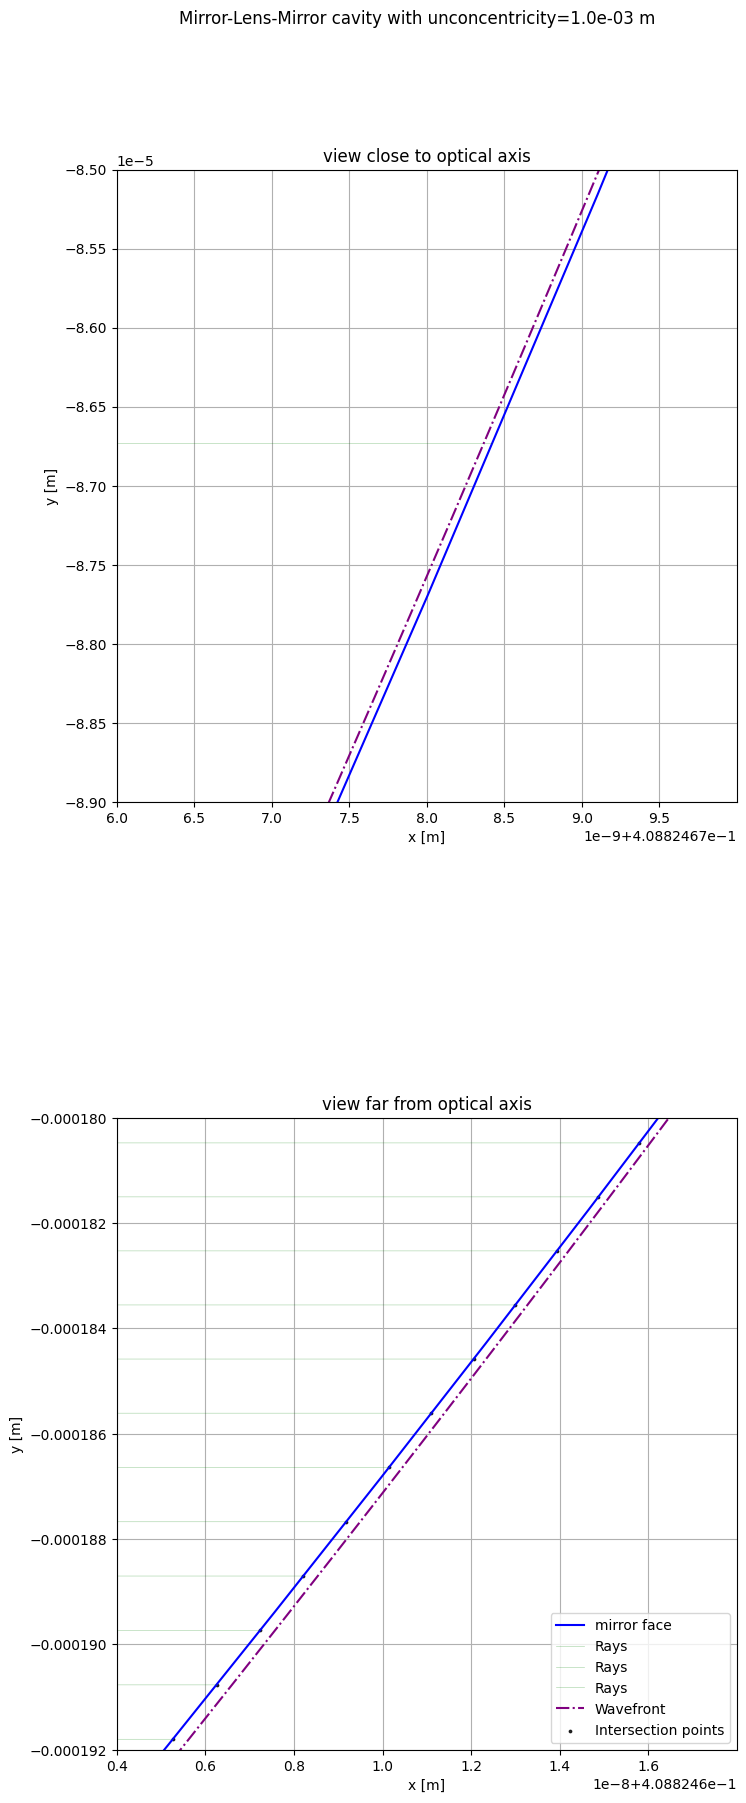

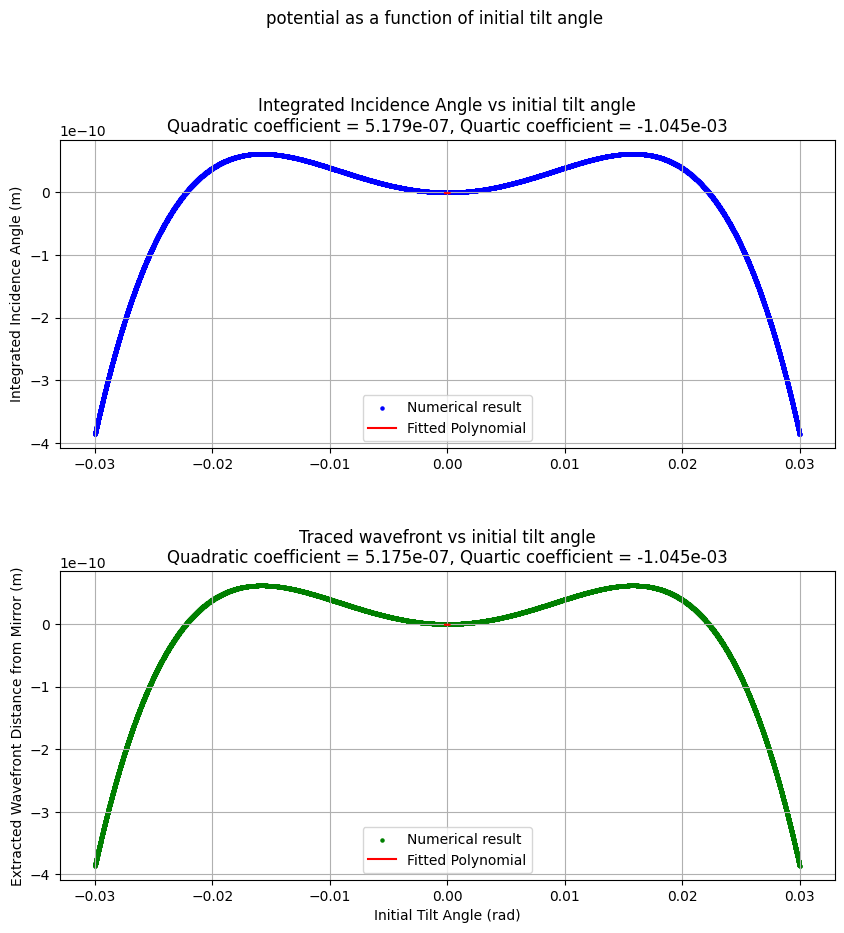

In [7]:
plt.close('all')
results_dict = find_wavefront_deviation(
    cavity=cavity_unconcentricity_small, max_initial_angle=0.03, n_rays=10000, plot_wavefronts=True, plot_potential_fits=True,
    plot_first_mirror_arc=False, print_summary=True,
    angles_parity_sign=-1,

    suptitles=f"Mirror-Lens-Mirror cavity with unconcentricity={unconcentricity_value:.1e} m")
cavity_unconcentricity_0.physical_surfaces[-1].plot(ax=results_dict['ax_wavefronts'][1],
                                                    label="right mirror face - 0 unconcentricity",
                                                    color='orange', linestyle='--')
results_dict['ax_wavefronts'][0].set_xlim(0.40882467 + 6e-9, 0.40882467 + 10e-9)
results_dict['ax_wavefronts'][0].set_ylim(-8.9e-5, -8.5e-5)
results_dict['ax_wavefronts'][0].set_title('view close to optical axis')
results_dict['ax_wavefronts'][1].set_xlim(0.4088246 + 0.4e-8, 0.4088246 + 1.8e-8)
results_dict['ax_wavefronts'][1].set_ylim(-0.000192, -0.000180)
results_dict['ax_wavefronts'][1].set_title('view far from optical axis')

results_dict = find_wavefront_deviation(
    cavity=cavity_unconcentricity_small, max_initial_angle=0.03, n_rays=10000, plot_wavefronts=False, plot_potential_fits=True,
    plot_first_mirror_arc=False, print_summary=True,
    angles_parity_sign=-1, potential_fits_x_axis='tilt_angle',
    suptitles=f"potential as a function of initial tilt angle")
plt.show()

Rays going from the big mirror to the small mirror:

wavefront distance from mirror according to wave front tracing = -1.461e-05m
wavefront distance from mirror according to angle of incidence integration = -1.462e-05m
polynomial quadratic and quartic coefficients for incidence angle integration method: -3.849e-01, -1.167e+06


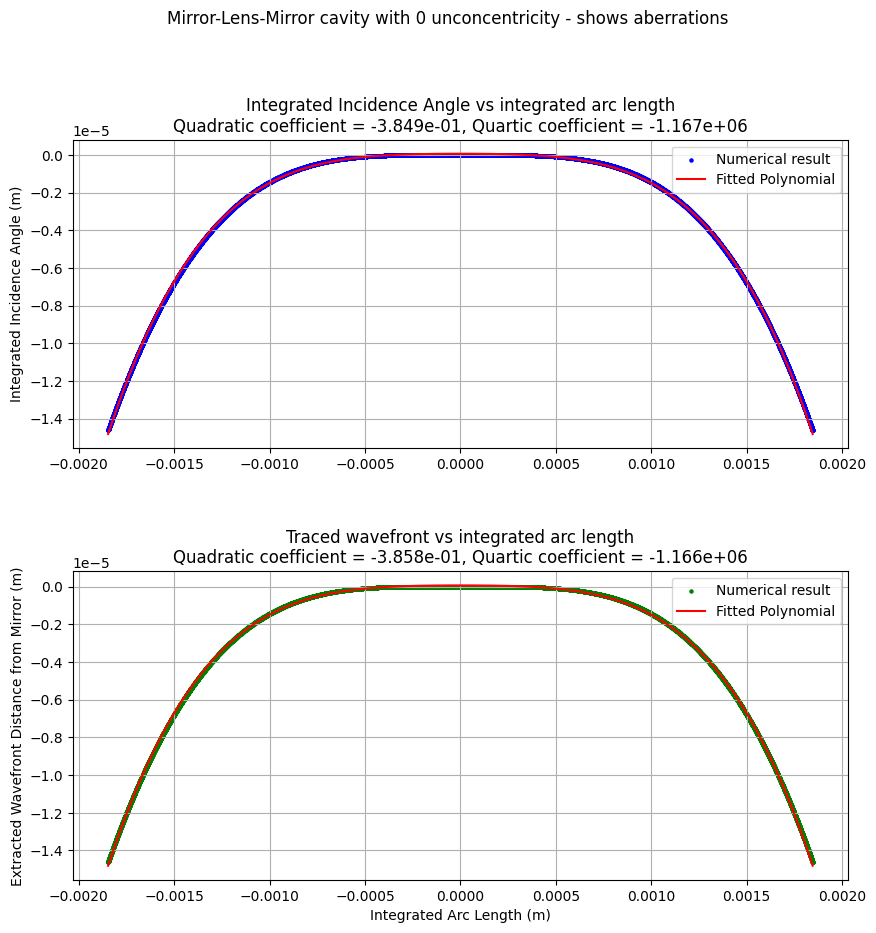

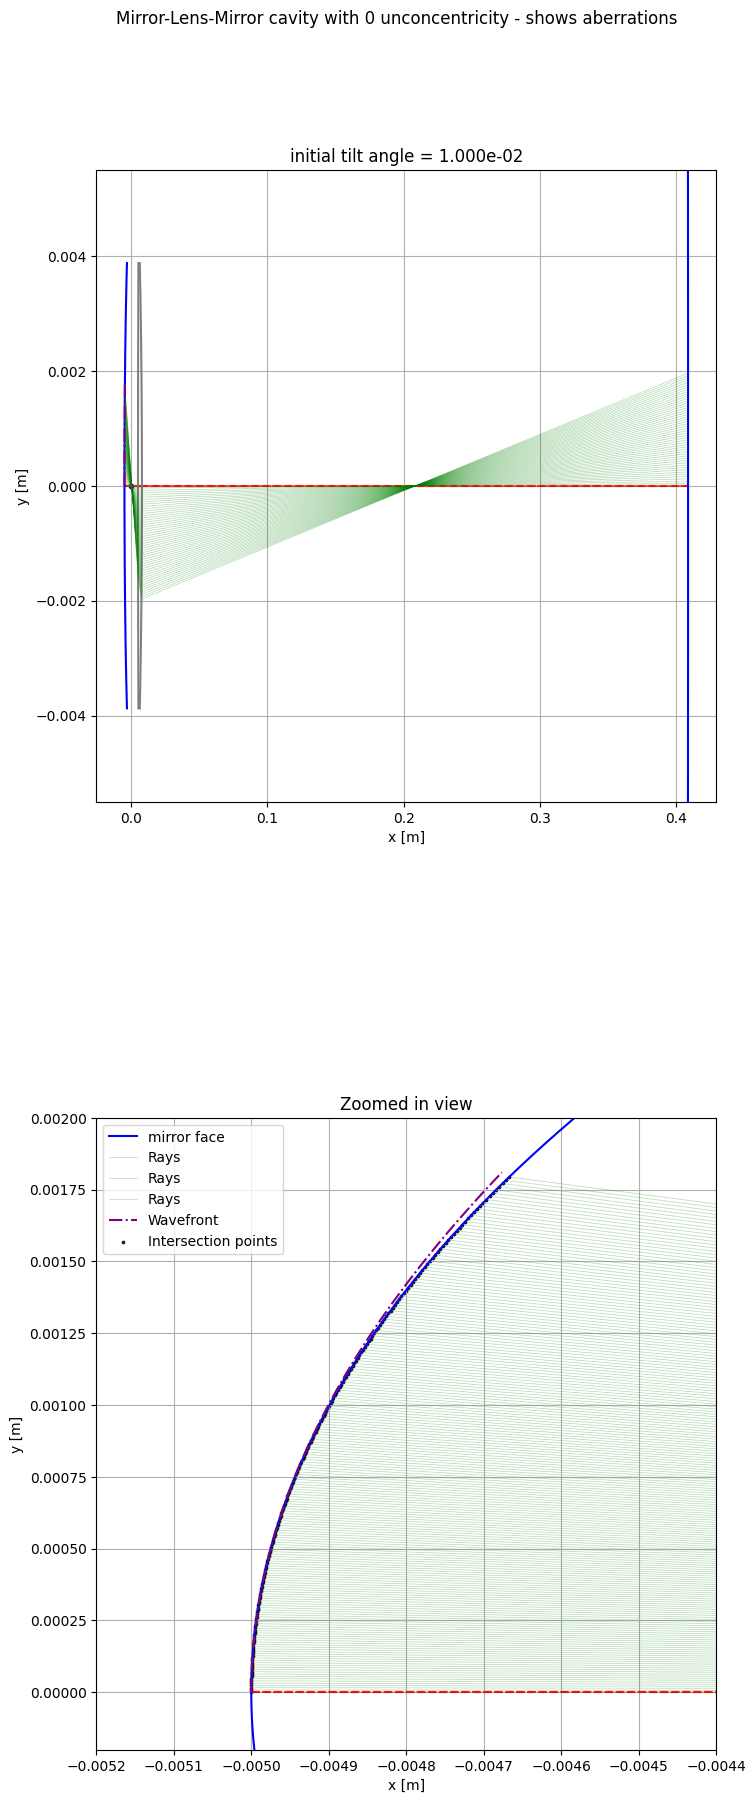

In [8]:
base_params_inverted = reverse_elements_order_of_mirror_lens_mirror(cavity_unconcentricity_0.to_params)
cavity_unconcentricity_0_inverted = Cavity.from_params(base_params_inverted,
                                                       standing_wave=True,
                                                       lambda_0_laser=LAMBDA_0_LASER,
                                                       set_central_line=True,
                                                       set_mode_parameters=False,
                                                       set_initial_surface=False,
                                                       t_is_trivial=True,
                                                       p_is_trivial=True,
                                                       use_paraxial_ray_tracing=False,
                                                       debug_printing_level=1,)
plt.close('all')
results_dict = find_wavefront_deviation(
    cavity=cavity_unconcentricity_0_inverted, max_initial_angle=0.01, n_rays=10000, plot_wavefronts=True, plot_potential_fits=True,
    plot_first_mirror_arc=False, print_summary=True, secondary_axis_limits=(-0.0052, -0.0044, -0.0002, 0.002),
    angles_parity_sign=-1,
    suptitles="Mirror-Lens-Mirror cavity with 0 unconcentricity - shows aberrations")
df = pd.DataFrame({'initial angle': results_dict['tilt_angles'],
                   'arc_length': results_dict['integrated_arc_lengths'],
                   'incidence angle': results_dict['incidence_angles'],
                   'distance from mirror': results_dict['integrated_divergence']})
df.to_csv(r'outputs\tables\cavity_angles_large_to_small.csv')